In [1]:
import pickle
import boris_extraction as boris
import multirecording_spikeanalysis as spike
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import sem
from itertools import combinations
from matplotlib_venn import venn2, venn3
def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))

c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Wilcoxon Single Cell Analysis

In [2]:
phase3_collection = unpickle_this('phase3collection.pkl')
phase3_analysis = spike.SpikeAnalysis_MultiRecording(phase3_collection, timebin = 100, ignore_freq = 0.5)

All set to analyze


In [3]:
           #offset included                    offset excluded 
# 2, 5, -2 =      80                                 72
# 1 , 5, -2 =     65                                  65
# 0, 6, -1 =      65                                       
# 1, 5, -1 =      64                                  58
# 2, 4, 1 =       62
# 3, 5, 0 =       62
# 3, 5, -1 =      61
# 3, 5, -2 =      61                                  
# 2, 4, -1 =      71                                  73
# 2, 4, 0 =       59         
# 3, 4, 0 =       59

In [4]:
equalize = 3
baseline_window = 1
offset = 0
print(phase3_analysis.fishers_exact_wilcox('novel', 'cagemate', equalize = equalize, baseline_window=baseline_window,offset= offset, event3 = None))
phase3_analysis.fishers_exact_wilcox('familiar', 'acquisition',equalize = equalize, baseline_window=baseline_window,offset= offset, event3 = None)

Wilcoxon can't be done on 20230809_103121_1_merged.rec novel, because <6 samples
Wilcoxon can't be done on 20230809_143303_1_merged.rec cagemate, because <6 samples
(0.7145884846344048, 0.3759465941091623, [[17, 149], [19, 119]])
Wilcoxon can't be done on 20230809_103121_1_merged.rec familiar, because <6 samples
Wilcoxon can't be done on 20230810_140909_1_merged.rec familiar, because <6 samples


(1.6766355140186915, 0.1349124403847154, [[23, 107], [20, 156]])

In [5]:
for event in ['novel', 'cagemate', 'familiar']:
    phase3_analysis.wilcox_baseline_v_event_collection(event=event, equalize =equalize, baseline_window=baseline_window, offset=offset, plot = False, save = True)
    phase3_analysis.wilcox_event_v_event_collection(event1=event, event2='baseline', equalize =equalize, pre_window=baseline_window,  plot = False, save = True)

Wilcoxon can't be done on 20230809_103121_1_merged.rec novel, because <6 samples
Wilcoxon can't be done on 20230809_143303_1_merged.rec cagemate, because <6 samples
Wilcoxon can't be done on 20230809_103121_1_merged.rec familiar, because <6 samples
Wilcoxon can't be done on 20230810_140909_1_merged.rec familiar, because <6 samples


In [6]:
df_list = []
for comparison in ['3s novel vs 1s baseline', '3s cagemate vs 1s baseline', '3s familiar vs 1s baseline']:
    df = phase3_collection.wilcox_dfs[comparison]
    df_list.append(df)

is_first = True 
for df in df_list:
    if is_first:
        presniff_master_df = df[['Subject', 'Recording', 'original unit id', 
                            'Event','event1 vs event2']]
        is_first = False
    else: 
        temp_df = df[['Subject', 'Recording', 'original unit id', 
                            'Event', 'event1 vs event2']]
        presniff_master_df = presniff_master_df.merge(temp_df,  on=['Subject', 'Recording', 'original unit id'], how = 'left')
    
#novel vs baseline

In [7]:
presniff_master_df.columns = ['Subject',
 'Recording',
 'original unit id',
 'Event_x',
 'novel vs baseline',
 'Event_y',
 'cagemate vs baseline',
 'Event_x',
 'familiar vs baseline']
presniff_master_df = presniff_master_df[['original unit id',
 'novel vs baseline',
 'cagemate vs baseline',
 'familiar vs baseline']]
presniff_master_df

,original unit id,novel vs baseline,cagemate vs baseline,familiar vs baseline
0,0,NaN,NaN,NaN
1,45,not significant,NaN,not significant
2,289,not significant,NaN,increases
3,279,increases,NaN,not significant
4,293,not significant,NaN,not significant
...,...,...,...,...
162,76,not significant,not significant,not significant
163,149,not significant,increases,not significant
164,135,not significant,not significant,not significant
165,38,not significant,increases,not significant


In [8]:
def group_cells(novel, cagemate, fam, acquisition=None):
    group = ''
    if (novel == 'increases') or (novel == 'decreases'):
        group = 'novel'
    if (cagemate == 'increases') or (cagemate == 'decreases'):
        group = group + 'cagemate' 
    if (fam == 'increases') or (fam == 'decreases'):
        group = group + 'fam'
    if acquisition is not None: 
        if (acquisition == 'increases') or (acquisition == 'decreases'):
            group = group + 'acquisition'
    return group

presniff_master_df['cell group'] = presniff_master_df.apply(lambda row: group_cells(row['novel vs baseline'],
                                                                  row['cagemate vs baseline'],
                                                                  row['familiar vs baseline']), axis = 1)
presniff_results = presniff_master_df.groupby('cell group').count()
presniff_results

,original unit id,novel vs baseline,cagemate vs baseline,familiar vs baseline
cell group,,,,
,118,117,100,83
cagemate,13,13,13,11
fam,19,19,6,19
novel,11,11,6,11
novelcagemate,2,2,2,2
novelfam,4,4,1,4


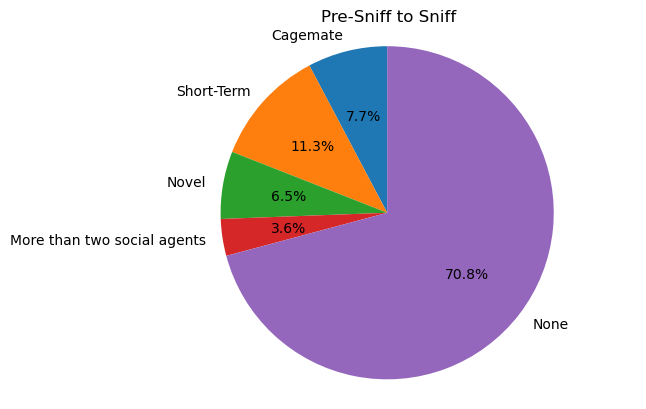

In [9]:
def plot_pie_chart(labels, sizes, title):
    """
    Plot a pie chart.

    Parameters:
    labels (list of str): Labels for each slice of the pie.
    sizes (list of float): Sizes of each slice (should sum to 100%).
    title (str): Title for the pie chart.
    """
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.set_title(title)
    plt.show()

# Example usage:
plot_pie_chart(['Cagemate', 'Short-Term', 'Novel', 'More than two social agents', 'None'], 
               [13, 19, 11, 6, 119], 'Pre-Sniff to Sniff')

In [10]:
df_list = []
for comparison in ['novel vs baseline (3s)', 'cagemate vs baseline (3s)', 'familiar vs baseline (3s)']:
    df = phase3_collection.wilcox_dfs[comparison]
    df_list.append(df)

is_first = True 
for df in df_list:
    if is_first:
        baseline_master_df = df[['Subject', 'Recording', 'original unit id', 
                            'Event','event1 vs event2']]
        is_first = False
    else: 
        temp_df = df[['Subject', 'Recording', 'original unit id', 
                            'Event', 'event1 vs event2']]
        baseline_master_df = baseline_master_df.merge(temp_df,  on=['Subject', 'Recording', 'original unit id'], how = 'left')

baseline_master_df.columns = ['Subject',
 'Recording',
 'original unit id',
 'Event_x',
 'novel vs iti',
 'Event_y',
 'cagemate vs iti',
 'Event_x',
 'familiar vs iti']
baseline_master_df = baseline_master_df[['original unit id',
 'novel vs iti',
 'cagemate vs iti',
 'familiar vs iti']]
baseline_master_df   

def group_cells(novel, cagemate, fam, acquisition=None):
    group = ''
    if (novel == 'increases') or (novel == 'decreases'):
        group = 'novel'
    if (cagemate == 'increases') or (cagemate == 'decreases'):
        group = group + 'cagemate' 
    if (fam == 'increases') or (fam == 'decreases'):
        group = group + 'fam'
    if acquisition is not None: 
        if (acquisition == 'increases') or (acquisition == 'decreases'):
            group = group + 'acquisitiimpoon'
    return group

baseline_master_df['cell group iti'] = baseline_master_df.apply(lambda row: group_cells(row['novel vs iti'],
                                                                  row['cagemate vs iti'],
                                                                  row['familiar vs iti']), axis = 1)
iti_results = baseline_master_df.groupby('cell group iti').count()
iti_results

,original unit id,novel vs iti,cagemate vs iti,familiar vs iti
cell group iti,,,,
,68,68,68,68
cagemate,12,12,12,12
cagematefam,11,11,11,11
fam,15,15,15,15
novel,9,9,9,9
novelcagemate,12,12,12,12
novelcagematefam,35,35,35,35
novelfam,14,14,14,14


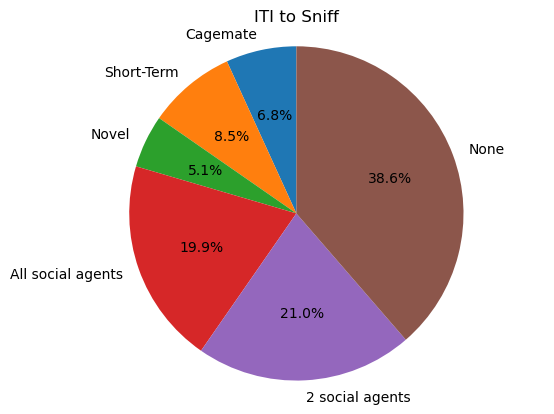

In [11]:
def plot_pie_chart(labels, sizes, title):
    """
    Plot a pie chart.

    Parameters:
    labels (list of str): Labels for each slice of the pie.
    sizes (list of float): Sizes of each slice (should sum to 100%).
    title (str): Title for the pie chart.
    """
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.set_title(title)
    plt.show()

# Example usage:
plot_pie_chart(['Cagemate', 'Short-Term', 'Novel', 'All social agents',
                '2 social agents', 'None'], 
               [12, 15, 9, 35, 37, 68], 'ITI to Sniff')

In [12]:

total_master_df = pd.merge(baseline_master_df, presniff_master_df, on='original unit id')
total_master_df = total_master_df[(total_master_df['cell group iti'] != "") | 
                                  (total_master_df['cell group'] != "")]
cagemate_master_df = total_master_df[(total_master_df['cell group iti'] == "cagemate") | 
                                  (total_master_df['cell group'] == "cagemate")]
recall_master_df = total_master_df[(total_master_df['cell group iti'] == "fam") | 
                                  (total_master_df['cell group'] == "fam")]
novel_master_df = total_master_df[(total_master_df['cell group iti'] == "novel") | 
                                  (total_master_df['cell group'] == "novel")]

In [13]:
plt.rcParams['font.weight'] = 'bold'  # Set font weight to bold (not bold)
plt.rcParams['axes.titleweight'] = 'bold'  # Set axis title font weight to bold
plt.rcParams['axes.labelweight'] = 'bold' 

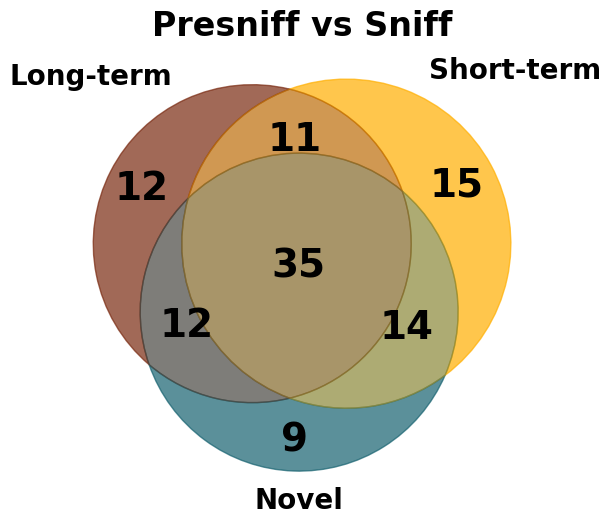

In [21]:
set1 = set(baseline_master_df.index[(baseline_master_df['cagemate vs iti'] == 'increases') |
                                    (baseline_master_df['cagemate vs iti'] == 'decreases')])
set2 = set(baseline_master_df.index[(baseline_master_df['familiar vs iti'] == 'increases') |
                                    (baseline_master_df['familiar vs iti'] == 'decreases')])
set3 = set(baseline_master_df.index[(baseline_master_df['novel vs iti'] == 'increases')|
                                    (baseline_master_df['novel vs iti'] == 'decreases')])

# Plot the Venn diagram
plt.figure(figsize=(8, 6))
venn = venn3([set1, set2, set3], ('Long-term', 'Short-term', 'Novel'))
venn.get_patch_by_id('100').set_color('#792910')  # Only in Set 1
venn.get_patch_by_id('010').set_color('#FFAF00')  # Only in Set 2
venn.get_patch_by_id('001').set_color('#15616F')  # Only in Set 3
venn.get_patch_by_id('110').set_color('#bc6c08')  # In Set 1 and Set 2
venn.get_patch_by_id('101').set_color('#474640')  # In Set 1 and Set 3
venn.get_patch_by_id('011').set_color('#8a8838')  # In Set 2 and Set 3
venn.get_patch_by_id('111').set_color('#84682a')  # In all Sets

# Optionally, set transparency
for subset in ('100', '010', '001', '110', '101', '011', '111'):
    venn.get_patch_by_id(subset).set_alpha(0.7)

for text in venn.set_labels:
    text.set_fontsize(20)  # Set label font size

for text in venn.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(28) 
# Show the plot
plt.title('Presniff vs Sniff', fontsize = 24)
plt.savefig('phase3_venn_baseline.png', format='png', dpi=600, transparent = True)
plt.show()
plt.show()

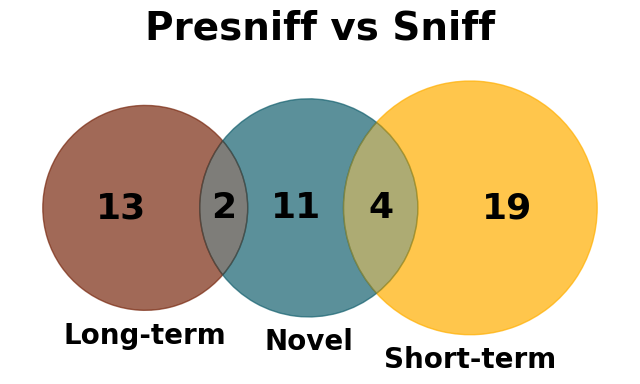

In [22]:
set1 = set(presniff_master_df.index[(presniff_master_df['cagemate vs baseline'] == 'increases')|
                                    (presniff_master_df['cagemate vs baseline'] == 'decreases')])
set2 = set(presniff_master_df.index[(presniff_master_df['familiar vs baseline'] == 'increases')|
                                    (presniff_master_df['familiar vs baseline'] == 'decreases')])
set3 = set(presniff_master_df.index[(presniff_master_df['novel vs baseline'] == 'increases')|
                                    (presniff_master_df['novel vs baseline'] == 'decreases')])

# Plot the Venn diagram
plt.figure(figsize=(8, 6))
venn = venn3([set1, set2, set3], ('Long-term', 'Short-term', 'Novel'))
venn.get_patch_by_id('100').set_color('#792910')  # Only in Set 1
venn.get_patch_by_id('010').set_color('#FFAF00')  # Only in Set 2
venn.get_patch_by_id('001').set_color('#15616F')  # Only in Set 3
#venn.get_patch_by_id('110').set_color('#bc6c08')  # In Set 1 and Set 2
venn.get_patch_by_id('101').set_color('#474640')  # In Set 1 and Set 3
venn.get_patch_by_id('011').set_color('#8a8838')  # In Set 2 and Set 3
#venn.get_patch_by_id('111').set_color('#84682a')  # In all Sets

# Optionally, set transparency
for subset in ('100', '010', '001', '101', '011'):
    venn.get_patch_by_id(subset).set_alpha(0.7)

for text in venn.set_labels:
    text.set_fontsize(20)  # Set label font size

for text in venn.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(26) 
# Show the plot
plt.title('Presniff vs Sniff', fontsize = 28)
plt.savefig('phase3_venn_presniff.png', format='png', dpi=600, transparent = True)
plt.show()
plt.show()

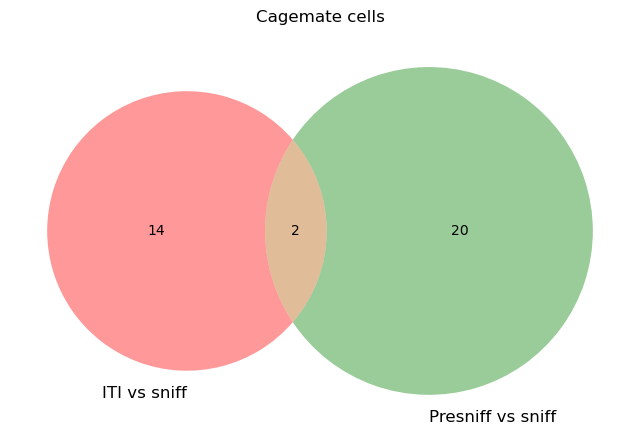

In [ ]:
set1 = set(cagemate_master_df.index[cagemate_master_df['cell group iti'] == 'cagemate'])
set2 = set(cagemate_master_df.index[cagemate_master_df['cell group'] == 'cagemate'])

# Plot the Venn diagram
plt.figure(figsize=(8, 6))
venn2([set1, set2], ('ITI vs sniff', 'Presniff vs sniff'))

# Show the plot
plt.title('Cagemate cells')
plt.show()

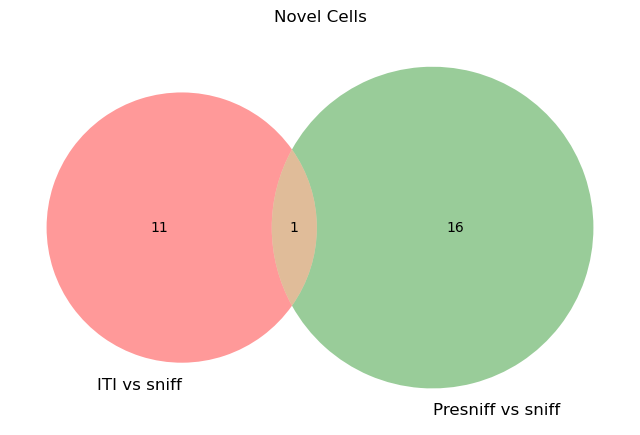

In [ ]:
set1 = set(novel_master_df.index[novel_master_df['cell group iti'] == 'novel'])
set2 = set(novel_master_df.index[novel_master_df['cell group'] == 'novel'])

# Plot the Venn diagram
plt.figure(figsize=(8, 6))
venn2([set1, set2], ('ITI vs sniff', 'Presniff vs sniff'))

# Show the plot
plt.title('Novel Cells')
plt.show()

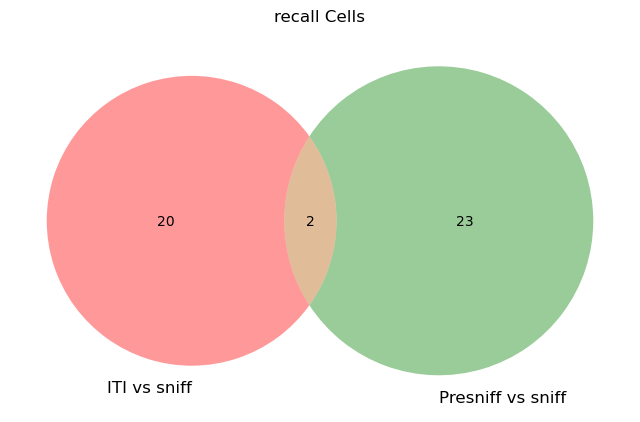

In [ ]:
set1 = set(recall_master_df.index[recall_master_df['cell group iti'] == 'fam'])
set2 = set(recall_master_df.index[recall_master_df['cell group'] == 'fam'])

# Plot the Venn diagram
plt.figure(figsize=(8, 6))
venn2([set1, set2], ('ITI vs sniff', 'Presniff vs sniff'))

# Show the plot
plt.title('recall Cells')
plt.show()